# 1-D and 2-D Convolutional Neural Networks in Pytorch

In this assignment, we will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  We will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [14]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [ ]:
class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)

        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4.

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [ ]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [ ]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.442
adam: Epoch 4 Loss 0.294
adam: Epoch 6 Loss 0.247
adam: Epoch 8 Loss 0.226
adam: Epoch 10 Loss 0.210
adam: Epoch 12 Loss 0.193
adam: Epoch 14 Loss 0.185
adam: Epoch 16 Loss 0.177
adam: Epoch 18 Loss 0.172
adam: Epoch 20 Loss 0.168


Text(0.5, 1.0, 'MNIST')

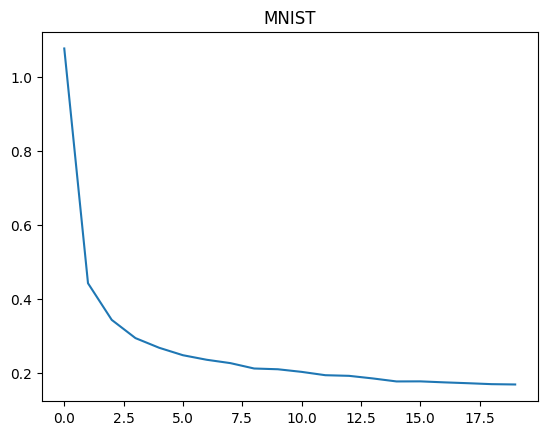

In [ ]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)),
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet.error_trace = [e.detach().cpu().numpy() for e in cnnet.error_trace]

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [ ]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [ ]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 93.73


,0,1,2,3,4,5,6,7,8,9
0,96.632653,0.000000,0.714286,0.000000,0.102041,0.408163,1.224490,0.306122,0.408163,0.204082
1,0.000000,96.740088,1.850220,0.176211,0.088106,0.000000,0.352423,0.000000,0.704846,0.088106
2,0.484496,1.065891,94.186047,1.259690,0.193798,0.000000,0.775194,0.968992,1.065891,0.000000
3,0.000000,0.396040,0.792079,92.772277,0.000000,2.475248,0.099010,1.881188,1.485149,0.099010
4,0.305499,0.712831,0.203666,0.101833,95.213849,0.101833,0.712831,0.203666,0.509165,1.934827
5,0.448430,0.000000,0.224215,2.802691,0.560538,91.816143,0.784753,0.672646,2.017937,0.672646
6,1.774530,0.208768,0.835073,0.208768,1.461378,0.521921,94.780793,0.000000,0.208768,0.000000
7,0.000000,1.556420,0.778210,1.361868,0.291829,0.000000,0.097276,93.579767,0.486381,1.848249
8,0.513347,0.616016,1.026694,2.977413,0.821355,1.848049,0.410678,0.102669,90.657084,1.026694
9,0.792864,0.000000,0.000000,0.000000,3.865213,0.991080,0.000000,2.378593,1.585728,90.386521


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets.

In [ ]:
import pandas as pd

n_hiddens_per_conv_layer = [[10], [10, 10], [10, 10, 10]]
patch_size_per_conv_layer = [[5], [5, 5], [5, 5, 5]]
stride_per_conv_layer=[[1], [1, 1], [1, 1, 1]]
n_hiddens_per_fc_layer = []

n_epochs = 20
batch_size = 500
learning_rate = 0.01

results = []

for i in range(3):
    print(f'Training with architecture {i}')
    cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer[i], n_hiddens_per_fc_layer, len(np.unique(Ttrain)),
                patch_size_per_conv_layer[i], stride_per_conv_layer[i], device=device)
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

    classes_train, _ = cnnet.use(Xtrain)
    train_correct = 100 * np.mean(classes_train == Ttrain)

    classes_test, _ = cnnet.use(Xtest)
    test_correct = 100 * np.mean(classes_test == Ttest)

    results.append([n_hiddens_per_conv_layer[i], train_correct, test_correct])

pd.DataFrame(results, columns=['convolutional layers', 'train_correct', 'test_correct'])

Training with architecture 0
adam: Epoch 2 Loss 0.316
adam: Epoch 4 Loss 0.209
adam: Epoch 6 Loss 0.169
adam: Epoch 8 Loss 0.140
adam: Epoch 10 Loss 0.128
adam: Epoch 12 Loss 0.110
adam: Epoch 14 Loss 0.114
adam: Epoch 16 Loss 0.095
adam: Epoch 18 Loss 0.100
adam: Epoch 20 Loss 0.095
Training with architecture 1
adam: Epoch 2 Loss 0.194
adam: Epoch 4 Loss 0.141
adam: Epoch 6 Loss 0.178
adam: Epoch 8 Loss 0.189
adam: Epoch 10 Loss 0.165
adam: Epoch 12 Loss 0.127
adam: Epoch 14 Loss 0.151
adam: Epoch 16 Loss 0.146
adam: Epoch 18 Loss 0.143
adam: Epoch 20 Loss 0.116
Training with architecture 2
adam: Epoch 2 Loss 0.184
adam: Epoch 4 Loss 0.141
adam: Epoch 6 Loss 0.121
adam: Epoch 8 Loss 0.090
adam: Epoch 10 Loss 0.098
adam: Epoch 12 Loss 0.088
adam: Epoch 14 Loss 0.074
adam: Epoch 16 Loss 0.075
adam: Epoch 18 Loss 0.068
adam: Epoch 20 Loss 0.055


,convolutional layers,train_correct,test_correct
0,[10],97.496,95.39
1,"[10, 10]",98.330,96.22
2,"[10, 10, 10]",99.042,97.89


In [ ]:
n_hiddens_per_conv_layer = [10, 10, 10]
patch_size_per_conv_layer =  [5, 5, 5]
stride_per_conv_layer= [1, 1, 1]
n_hiddens_per_fc_layer = [[10], [10, 10], [10, 10, 10]]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

results = []

for i in range(3):
    print(f'Training with architecture {i}')
    cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer[i], len(np.unique(Ttrain)),
                patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

    classes_train, _ = cnnet.use(Xtrain)
    train_correct = 100 * np.mean(classes_train == Ttrain)

    classes_test, _ = cnnet.use(Xtest)
    test_correct = 100 * np.mean(classes_test == Ttest)

    results.append([n_hiddens_per_fc_layer[i], train_correct, test_correct])

pd.DataFrame(results, columns=['fc-layers', 'train_correct', 'test_correct'])

Training with architecture 0
adam: Epoch 2 Loss 0.326
adam: Epoch 4 Loss 0.224
adam: Epoch 6 Loss 0.213
adam: Epoch 8 Loss 0.217
adam: Epoch 10 Loss 0.201
adam: Epoch 12 Loss 0.181
adam: Epoch 14 Loss 0.188
adam: Epoch 16 Loss 0.167
adam: Epoch 18 Loss 0.183
adam: Epoch 20 Loss 0.170
Training with architecture 1
adam: Epoch 2 Loss 0.388
adam: Epoch 4 Loss 0.270
adam: Epoch 6 Loss 0.266
adam: Epoch 8 Loss 0.240
adam: Epoch 10 Loss 0.223
adam: Epoch 12 Loss 0.207
adam: Epoch 14 Loss 0.219
adam: Epoch 16 Loss 0.204
adam: Epoch 18 Loss 0.210
adam: Epoch 20 Loss 0.212
Training with architecture 2
adam: Epoch 2 Loss 0.458
adam: Epoch 4 Loss 0.326
adam: Epoch 6 Loss 0.306
adam: Epoch 8 Loss 0.275
adam: Epoch 10 Loss 0.246
adam: Epoch 12 Loss 0.250
adam: Epoch 14 Loss 0.223
adam: Epoch 16 Loss 0.242
adam: Epoch 18 Loss 0.226
adam: Epoch 20 Loss 0.227


,fc-layers,train_correct,test_correct
0,[10],95.486,95.67
1,"[10, 10]",94.054,94.45
2,"[10, 10, 10]",93.504,93.82


**In the first cell, I compared the test accuracy of CNN2D with different layers of convolutional layers, patch sizes, and strides. The pandas dataframe below that shows the accuracies of all three, of which the third with the three layers produced the best accuracy for both the training set and testing set. I then used this in the second cell, where I varied the numbers of the fully connected layers. The best performing one was the one with one layer and the worst was with three layers. There might be several reasons for these behaviours. For one, deeper networks with more fc layers require more data to generalize well, which this dataset might lack. With more training data, this result could change. There could also be information loss when adding more layers as the feature vector's dimensionality is reduced. This could lower accuracy because the model gets worse at discriminating the features.**

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [ ]:
class CNN1D(CNN2D):
    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(n_inputs)  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
                                Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [ ]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [ ]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

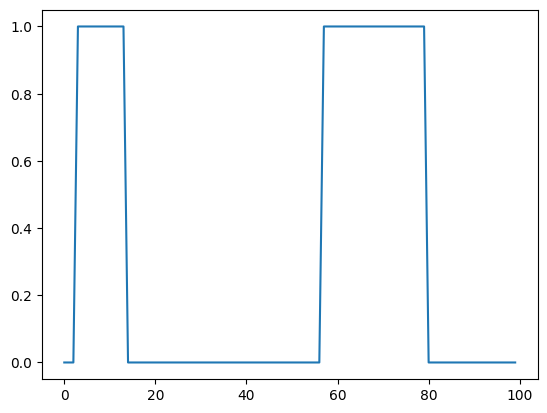

In [ ]:
plt.plot(square_pulse)

In [ ]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [ ]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11111111, 0.22222222, 0.33333

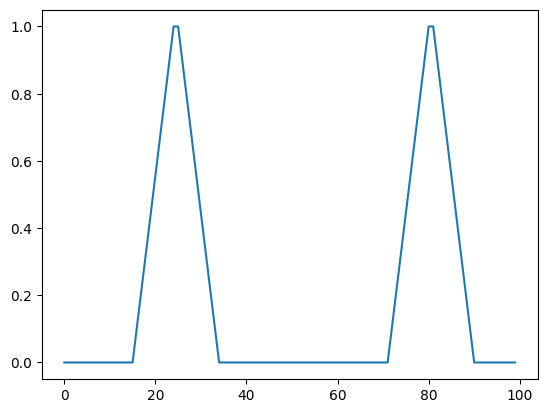

In [ ]:
plt.plot(triangular_pulse)

In [ ]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [ ]:
np.newaxis == None

True

In [ ]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [ ]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.566
adam: Epoch 20 Loss 0.364
adam: Epoch 30 Loss 0.209
adam: Epoch 40 Loss 0.139
adam: Epoch 50 Loss 0.075
adam: Epoch 60 Loss 0.037
adam: Epoch 70 Loss 0.011
adam: Epoch 80 Loss 0.002
adam: Epoch 90 Loss 0.001
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

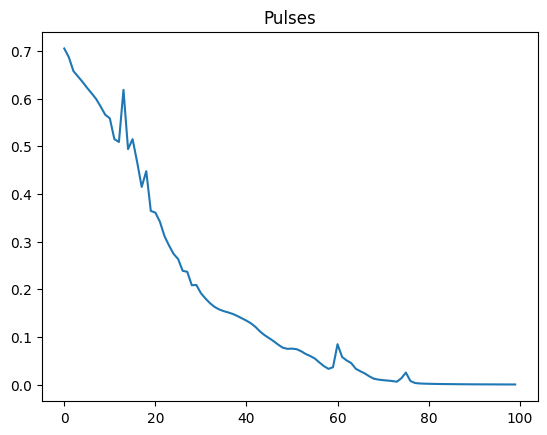

In [ ]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet1.error_trace = [e.detach().cpu().numpy() for e in cnnet1.error_trace]

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [ ]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.00


,square,triangular
square,98.2,1.8
triangular,0.2,99.8


torch.Size([10, 10])

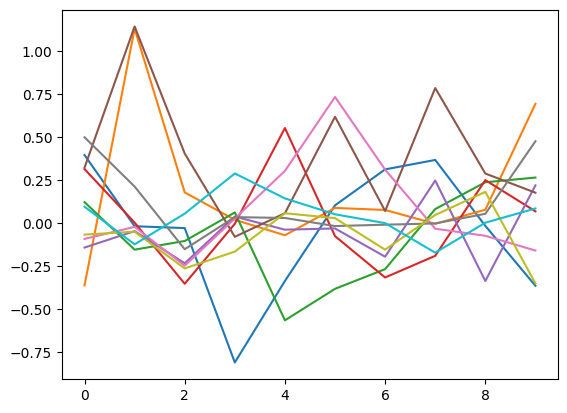

In [ ]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy)

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [ ]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

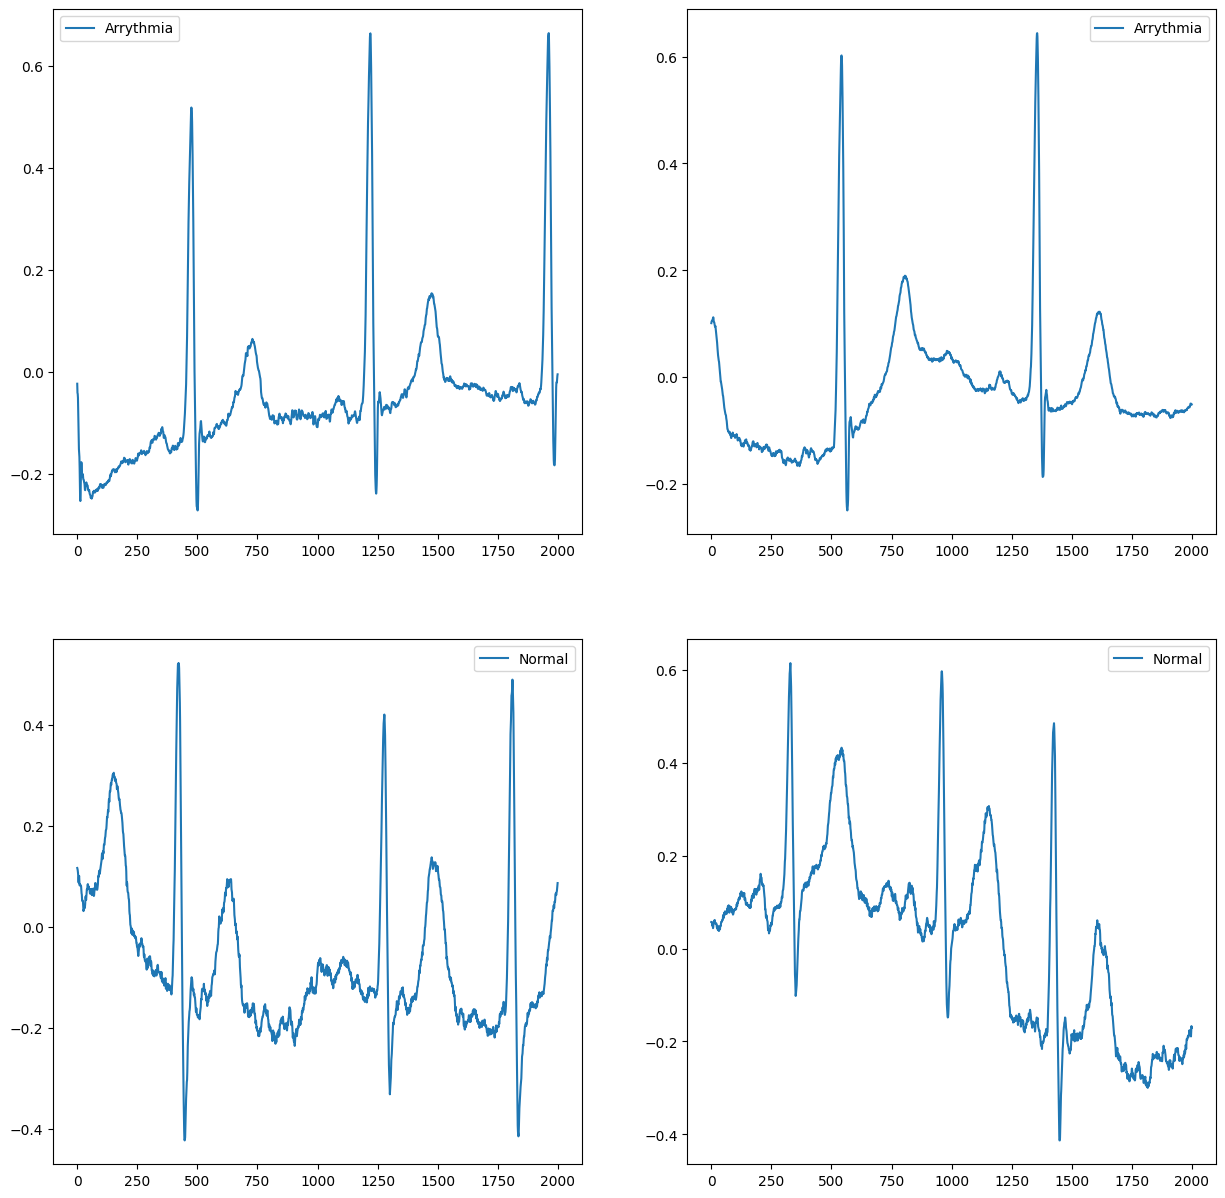

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [ ]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [ ]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['nr'],
       ['nr'],
       ['arr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [21]:
import pandas as pd

n_hiddens_per_conv_layer =  [[5], [10], [50], [5], [10], [50], [5, 5], [10, 10], [50, 50], [5, 5], [10, 10], [50, 50], [5, 5, 5], [10, 10, 10], [50, 50, 50], [50, 50, 50], [50, 50, 50]]
patch_size_per_conv_layer = [[5], [5], [5], [3], [3], [3], [5, 5], [5, 5], [5, 5], [3, 3], [3, 3], [3, 3], [3, 3, 3], [5, 5, 5], [10, 10, 10], [5, 5, 5], [5, 5, 5]]
stride_per_conv_layer =     [[1], [1], [1], [2], [2], [2], [1, 1], [1, 1], [3, 3], [1, 2], [1, 2], [1, 2], [3, 3, 3], [1, 1, 1], [2, 2, 2], [5, 5, 5], [5, 5, 5]]
n_hiddens_per_fc_layer=     [[10], [10], [10], [10, 10], [10, 10], [10, 10], [10], [10], [10], [10, 10], [10, 10], [10, 10], [5, 5], [10, 10, 10], [50], [100, 100], [100, 100, 100]]

n_epochs = 100
batch_size = 10
learning_rate = 0.001

results = []

for i in range(17):
    print(f'Training with architecture {i}')
    cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer[i], n_hiddens_per_fc_layer[i], 2,
                  patch_size_per_conv_layer[i], stride_per_conv_layer[i], device=device)
    cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate)

    classes_train, _ = cnn1d.use(Xtrain)
    train_correct = 100 * np.mean(classes_train == Ttrain)

    classes_test, _ = cnn1d.use(Xtest)
    test_correct = 100 * np.mean(classes_test == Ttest)

    results.append([n_hiddens_per_conv_layer[i], n_hiddens_per_fc_layer[i],
                   patch_size_per_conv_layer[i], stride_per_conv_layer[i], train_correct, test_correct])

df = pd.DataFrame(results, columns=['n_hiddens_per_conv_layer', 'n_hiddens_per_fc_layer',
                   'patch_size_per_conv_layer', 'stride_per_conv_layer', 'train_correct', 'test_correct'])
df

Training with architecture 0
sgd: Epoch 10 Loss 0.548
sgd: Epoch 20 Loss 0.457
sgd: Epoch 30 Loss 0.390
sgd: Epoch 40 Loss 0.356
sgd: Epoch 50 Loss 0.326
sgd: Epoch 60 Loss 0.289
sgd: Epoch 70 Loss 0.268
sgd: Epoch 80 Loss 0.269
sgd: Epoch 90 Loss 0.231
sgd: Epoch 100 Loss 0.252
Training with architecture 1
sgd: Epoch 10 Loss 0.533
sgd: Epoch 20 Loss 0.457
sgd: Epoch 30 Loss 0.413
sgd: Epoch 40 Loss 0.378
sgd: Epoch 50 Loss 0.358
sgd: Epoch 60 Loss 0.315
sgd: Epoch 70 Loss 0.304
sgd: Epoch 80 Loss 0.282
sgd: Epoch 90 Loss 0.251
sgd: Epoch 100 Loss 0.240
Training with architecture 2
sgd: Epoch 10 Loss 0.578
sgd: Epoch 20 Loss 0.541
sgd: Epoch 30 Loss 0.486
sgd: Epoch 40 Loss 0.468
sgd: Epoch 50 Loss 0.461
sgd: Epoch 60 Loss 0.427
sgd: Epoch 70 Loss 0.402
sgd: Epoch 80 Loss 0.388
sgd: Epoch 90 Loss 0.390
sgd: Epoch 100 Loss 0.370
Training with architecture 3
sgd: Epoch 10 Loss 0.584
sgd: Epoch 20 Loss 0.480
sgd: Epoch 30 Loss 0.398
sgd: Epoch 40 Loss 0.348
sgd: Epoch 50 Loss 0.310
sgd: E

,n_hiddens_per_conv_layer,n_hiddens_per_fc_layer,patch_size_per_conv_layer,stride_per_conv_layer,train_correct,test_correct
0,[5],[10],[5],[1],83.814433,65.375103
1,[10],[10],[5],[1],89.298969,67.518549
2,[50],[10],[5],[1],81.690722,63.808739
3,[5],"[10, 10]",[3],[2],90.206186,64.303380
4,[10],"[10, 10]",[3],[2],87.319588,65.787304
5,[50],"[10, 10]",[3],[2],83.278351,65.375103
6,"[5, 5]",[10],"[5, 5]","[1, 1]",98.721649,66.034625
7,"[10, 10]",[10],"[5, 5]","[1, 1]",60.247423,58.615004
8,"[50, 50]",[10],"[5, 5]","[3, 3]",99.030928,67.600989
9,"[5, 5]","[10, 10]","[3, 3]","[1, 2]",90.969072,65.952185


**In the table above, you can observe the train and test accuracy for 17 different architectures that have combinations of convolutional layers, patche sizes, strides, and fully connected layers. I mostly kept the patch size and strides constant and mostly made changes to the convolutional layers. For the single layers, you can see that more neurons does not translate to better accuracy as 5 and 10 performed better than 50. Increasing the number of layers did seem to produce a higher accuracy as two layers are higher than one and three is higher than two. This is most likely due to the network capturing more complex patterns in the data, which allows it to detect specific patterns. With 50 neurons, it produced the highest accuracies for the two layers, but it was lower the second time. I think the biggest impact was changing the fc_layer from one to two layers. For the three layers, they often prodced a training accuracy of 100 and the lowest loss values. It seems like a more complex network is better for this dataset. After experimenting with the convolutional layers, I changed some fully connected layers for the ones that were alredy performing well and this also increased with more neurons. You can see that the 15th row produced the highest test accuracy and a perfect accuracy for the training set. However, adding one more layer to the fc_layer actually decreased it. For all of the architectures, the test accuracy is more lower than the train accuracy, implying that there might be some overfitting occuring. This might be due to noise in the train dataset or if the model is too complex. I think more experimentation could be done by varying the patch sizes, strides, and layers taking row 15 as a starting point and improving on that.**